In [2]:
#standard
import numpy as np
np.random.seed(1) #fix seed for notebook
import pandas as pd
import scipy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

#ML
from xgboost import plot_importance, plot_tree
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [69]:
def CRPS(df_true, df_pred):
    loss=0
    q=np.arange(.01, 1.0, .01)
    for i in range(df_true.shape[0]):#cycles through each timestep
        y=df_true[i] #true value at timestep "i"
        yhat=df_pred.iloc[i,:] #quantile prediction at timestep "i"
        #CRPS loss
        loss=loss+sum([min(yhat)-y if y<min(yhat) else 0, 
        np.trapz(q[yhat <= y]**2, yhat[yhat <= y]),
        np.trapz((q[yhat >= y]-1)**2, yhat[yhat >= y]),
        y-max(yhat) if y>max(yhat) else 0])

    return loss/results.shape[0] #average CRPS at each timestep

In [2]:
def pinball_loss(df_true, df_pred):
    timestep_loss=0
    for j in range(df_true.shape[0]):#cycles through each time step

        for i in range(99):#cycles through 99 quantiles
            tl=df_true[j] #true load for timestep
            qlp=df_pred.iloc[j,i] #quantile load prediction for timestep
            if(tl<qlp):
                timestep_loss=timestep_loss+(1-(i/100))*(qlp-tl)
            if(tl>=qlp):
                timestep_loss=timestep_loss+(i/100)*(tl-qlp)

    return timestep_loss/(99*df_true.shape[0])

In [34]:
def create_features(df, kind=None, label=None):
    """
    Creates time series features from datetime index
    label=predicted target
    Can be used for creating features for load
    or weather model construction, by setting kind to 
    load
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['weekday'] = (df['date'].dt.dayofweek // 5 == 1).astype(int)
    if(kind=='load'):
        X = df[['weekday', 'year', 'dayofyear','hour',
                'month','dayofweek','quarter','dayofmonth', 'weekofyear','temp']]
#         X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear','weekday',]]
    else:
        X = df[['weekday', 'year', 'dayofyear','hour',
        'month','dayofweek','quarter','dayofmonth', 'weekofyear']]
#         X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [74]:
def predict_data(pred_task_number,n_estimators, metrics=None):
    """
    Enter what number task you want to predict.
    Returns full data set with predicted values included
    Also returns the length of the predicted 
    """
    full_data=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 1/L1-train.csv')
    task2=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 2/L2-train.csv')
    full_data=pd.concat([full_data,task2], ignore_index=True)
    predicted_size=task2.shape[0]
    if(pred_task_number > 2):
        for i in range(3,pred_task_number+1):
            temp=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task {}/L{}-train.csv'.format(i,i))
            full_data=pd.concat([full_data, temp], ignore_index=True)
            predicted_size=temp.shape[0] #nrows of predictied df
    ps=predicted_size
    
    nrows=full_data.shape[0]
    #generate date index for data
    dti = pd.date_range('2001-01-01 01:00', periods=nrows, freq='H')
    full_data['Date']=dti
    full_data=full_data.set_index('Date')

    #true load values
    results=full_data[dti[dti.shape[0]-ps]:]
    results=pd.DataFrame({'True_Load':results.LOAD.values}, index=results.index.copy())
    results #true load values to be compared to

    #weather matrix
    weather=full_data.drop(['ZONEID','TIMESTAMP','LOAD'], axis=1)
    weather_sd=weather.std(axis=1)*3
    dti_w = pd.date_range('2001-01-01 01:00', periods=nrows, freq='H')
    weather_data=pd.DataFrame({'Avg_Temp':weather.mean(axis=1).values,
                               'Low_Temp':weather.mean(axis=1).values-weather_sd,
                               'High_Temp':weather.mean(axis=1).values+weather_sd},index=dti_w)
    #True temp values
    results['Temp_True']=weather_data['Avg_Temp'].tail(ps)
    #drop the temp data we will predict on
    weather_data.drop(weather_data.tail(ps).index, inplace=True)

    #split weather data into train, test
    split_date = '1-1-2005'
    dfw_train = weather_data.loc[weather_data.index <= split_date].copy()
    dfw_test = weather_data.loc[weather_data.index > split_date].copy()



    #grab (Avg,Low, High)train,test features, only time dependent
    Xw_train, yw_train = create_features(dfw_train, label='Avg_Temp')
    Xw_test, yw_test = create_features(dfw_test, label='Avg_Temp')

    low_Xw_train, low_yw_train = create_features(dfw_train, label='Low_Temp')
    low_Xw_test, low_yw_test = create_features(dfw_test, label='Low_Temp')

    high_Xw_train, high_yw_train = create_features(dfw_train, label='High_Temp')
    high_Xw_test, high_yw_test = create_features(dfw_test, label='High_Temp')

    #fit weather Avg data model
    Avgregw = xgb.XGBRegressor(n_estimators=n_estimators,
                               objective ='reg:squarederror',
                           booster='gbtree',
                           max_depth=4,
                          learning_rate=.9,
                           min_child_weight=1)
    Avgregw.fit(Xw_train, yw_train,
            eval_set=[(Xw_train, yw_train), (Xw_test, yw_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train
    #fit weather Low data model
    Lowregw = xgb.XGBRegressor(n_estimators=n_estimators,
                               objective ='reg:squarederror',
                           booster='gbtree',
                           max_depth=4,
                          learning_rate=.9,
                           min_child_weight=1)
    Lowregw.fit(low_Xw_train, low_yw_train,
            eval_set=[(low_Xw_train, low_yw_train), (low_Xw_test, low_yw_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train

    #fit weather High data model
    Highregw = xgb.XGBRegressor(n_estimators=n_estimators,
                               objective ='reg:squarederror',
                           booster='gbtree',
                           max_depth=4,
                          learning_rate=.9,
                           min_child_weight=1)
    Highregw.fit(high_Xw_train, high_yw_train,
            eval_set=[(high_Xw_train, high_yw_train), (high_Xw_test, high_yw_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train


    #create time interval for predition for weather temps
    dti_p=dti[dti.shape[0]-ps:]
    pt=pd.DataFrame(data=None, index=dti_p)
    prediction_tf=create_features(pt)
    prediction_tf

    #predict (Avg, High, Low) weather temps for predicted task
    weather_pred=pd.DataFrame()
    weather_pred['Pred_Avg_Temp']=Avgregw.predict(prediction_tf)
    weather_pred['Pred_High_Temp']=Highregw.predict(prediction_tf)
    weather_pred['Pred_Low_Temp']=Lowregw.predict(prediction_tf)
    results['Pred_Temp']=weather_pred['Pred_Avg_Temp'].values

    #drop the true values for model construction
    full_data.drop(full_data.tail(ps).index, inplace=True)

    #drop nan values from full_data for load model
    load_data=full_data.dropna()
    #create load data with temp to fit model
    load_length=load_data.shape[0]
    load_values=load_data.LOAD.values
    w=load_data.drop(['ZONEID', 'TIMESTAMP','LOAD'],axis=1)
    mw=w.mean(axis=1)
    dti_l = pd.date_range('2005-01-01 01:00', periods=load_length, freq='H')
    load_df=pd.DataFrame({'LOAD': load_values,'temp':mw.values, 'index': dti_l})
    load_df=load_df.set_index('index')

    #split data for train/test
    split_date = '1-1-2010'
    dfl_train = load_df.loc[load_df.index <= split_date].copy()
    dfl_test = load_df.loc[load_df.index > split_date].copy()

    #create features for load model
    Xl_train, yl_train = create_features(dfl_train,kind='load', label='LOAD')
    Xl_test, yl_test = create_features(dfl_test, kind='load',label='LOAD')

    #train load/temp model from all data besides predicted data
    loadreg = xgb.XGBRegressor(n_estimators=n_estimators,
                               objective ='reg:squarederror',
                           booster='gbtree',
                           max_depth=4,
                          learning_rate=.9,
                           min_child_weight=1)
    loadreg.fit(Xl_train, yl_train,
            eval_set=[(Xl_train, yl_train), (Xl_test, yl_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train

    #adds weekday to prediction 
    prediction_tf['weekday'] = (prediction_tf['dayofweek'] // 5 == 1).astype(int)

    #predicts low temp load prediction
    prediction_tf['temp']=weather_pred['Pred_Low_Temp'].values
    results['Pred_Low_Load']=loadreg.predict(prediction_tf)

    #predicts average temp load forecast
    prediction_tf['temp']=weather_pred['Pred_Avg_Temp'].values
    results['Pred_Avg_Load']=loadreg.predict(prediction_tf)

    #predicts high temp load prediction
    prediction_tf['temp']=weather_pred['Pred_High_Temp'].values
    results['Pred_High_Load']=loadreg.predict(prediction_tf)

    #import benchmark data
    benchmark=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task {}/L{}-benchmark.csv'.format(pred_task_number-1,pred_task_number-1))
    benchmark=benchmark.drop(['ZONEID','TIMESTAMP'],axis=1)
    results['benchmark']=benchmark['0.01'].values

    #this creates the data frame to compare the true values
    columns=['0.01']
    x=0.01
    for i in range(98):
        x=round(x+.01,2)
        columns.append('{}'.format(x))
    pin=pd.DataFrame(columns=columns, index=dti_p)
    #adds the quantile values to the dataframe to compare to true values
    for i in range(results.shape[0]):
        a=np.linspace(results['Pred_Low_Load'][i], results['Pred_Avg_Load'][i], num=50)
        b=np.linspace(results['Pred_Avg_Load'][i], results['Pred_High_Load'][i], num=50)
        out_arr2 = np.concatenate((a[1:50], b), axis=None)
        out_arr2.sort(axis=0)
        pin.iloc[i]=out_arr2

    bench_CRPS=CRPS(results['True_Load'], benchmark)
    pred_CRPS=CRPS(results['True_Load'], pin)
    pred_mse=mean_squared_error(results['True_Load'],results['Pred_Avg_Load'])
    bench_mse=mean_squared_error(results['True_Load'],results['benchmark'])
    pred_pin=pinball_loss(results['True_Load'], pin)
    bench_pin=pinball_loss(results['True_Load'], benchmark)
    temp_mse=mean_squared_error(results['Temp_True'],results['Pred_Temp'])
    array = np.array(['Task {}'.format(pred_task_number),pred_mse,pred_pin,pred_CRPS,bench_mse,bench_pin,bench_CRPS,temp_mse]).reshape(1,8)


    if(pred_task_number==2):
        metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball','Pred_CRPS', 'Benchmark_MSE', 'Benchmark_Pinball','Benchmark_CRPS','Temp_MSE']
        metrics=pd.DataFrame(columns=metric_columns,data=array)
        #print('Frist time Pred_task_number:',pred_task_number)
    else:
        #print('Pred_task_number:',pred_task_number)
        metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball','Pred_CRPS', 'Benchmark_MSE', 'Benchmark_Pinball','Benchmark_CRPS','Temp_MSE']
        temp=pd.DataFrame(columns=metric_columns,data=array)
        metrics=metrics.append(temp)

    # Plot the forecast with the actuals
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    results['True_Load'].plot(ax=ax,style='.', label='True Load')
    results['benchmark'].plot(ax=ax,style='-',c='r', label='Benchmark')

    ax.set_xbound(lower=results.index[0], upper=results.index[-1])
    ax.set_ylim(0, 300)
    ax.fill_between(dti_p, results['Pred_High_Load'], results['Pred_Low_Load'], alpha=.25,label='Probability')
    plot = plt.suptitle('Forecast vs Actuals for between {} and {}'.format(results.index[0],results.index[-1]))
    plt.legend()
    plt.show()
    return metrics

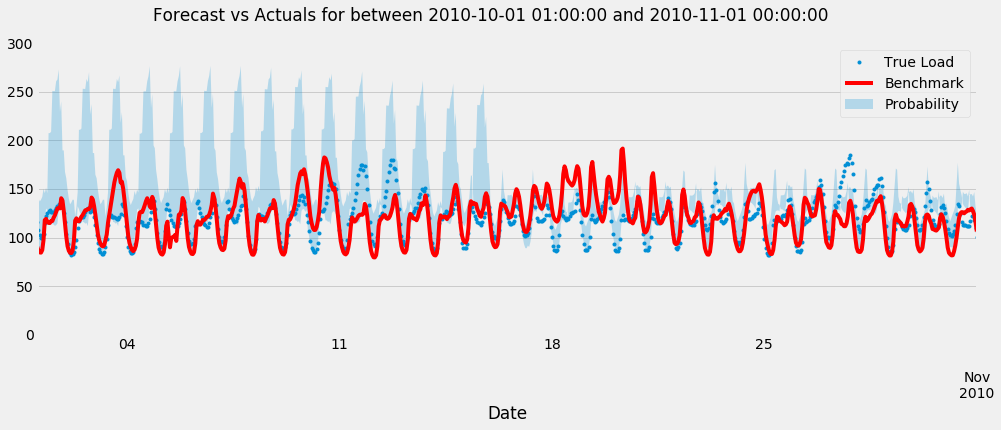

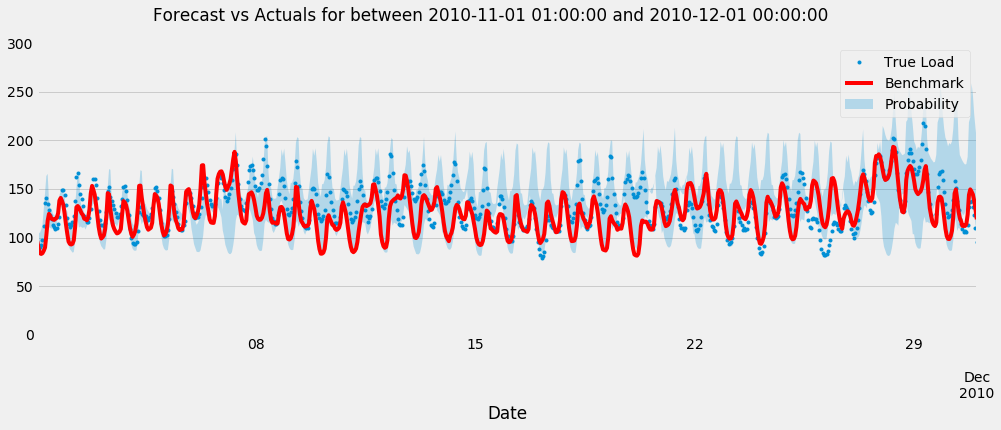

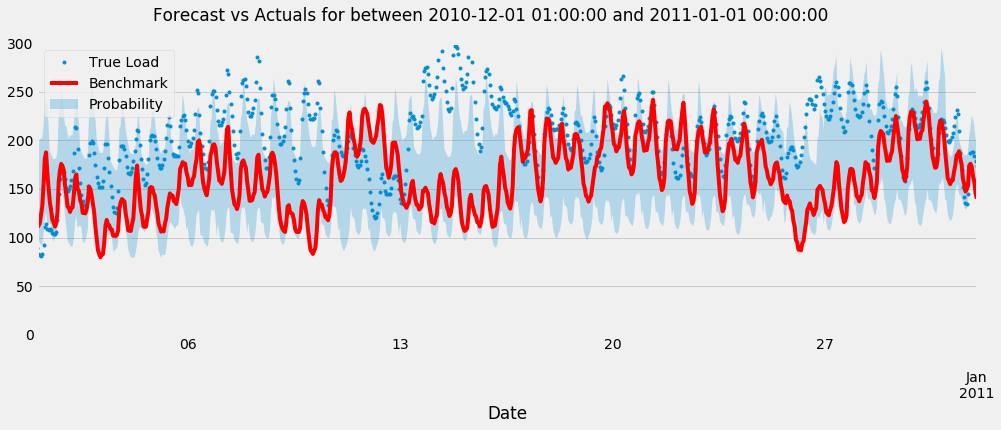

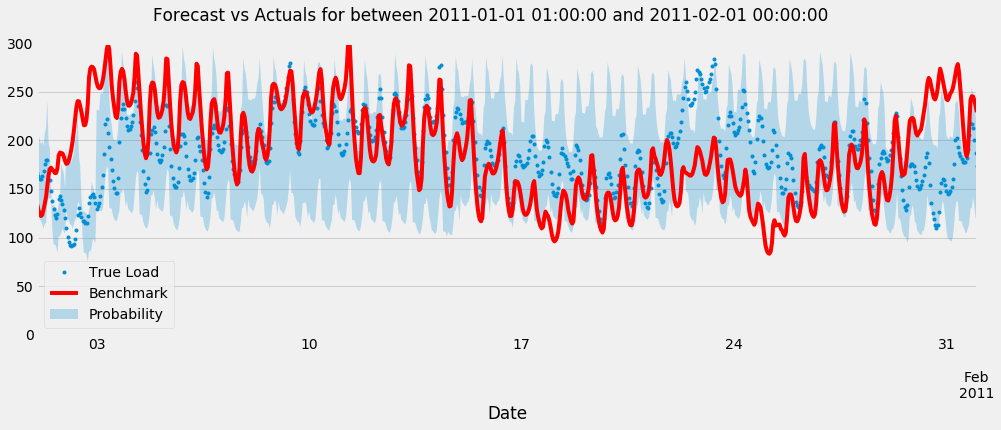

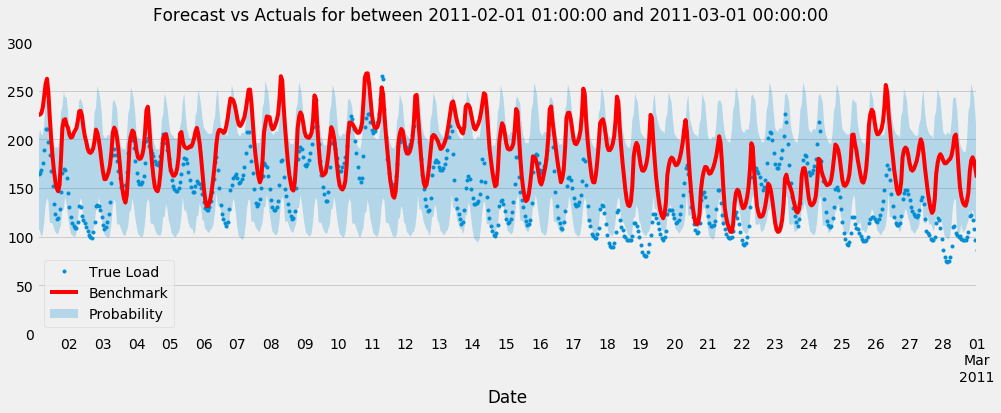

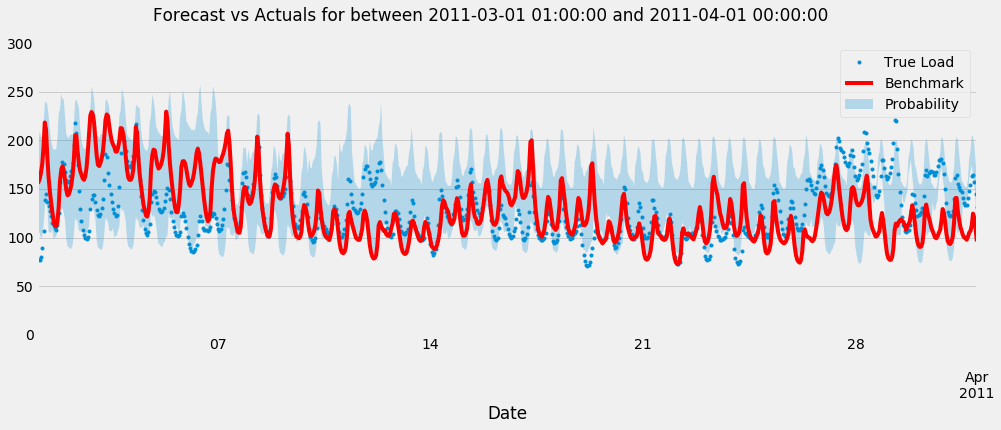

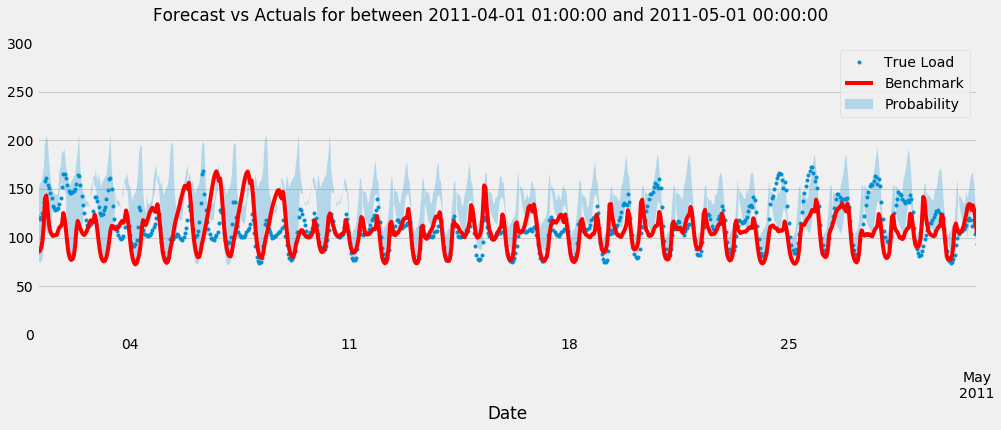

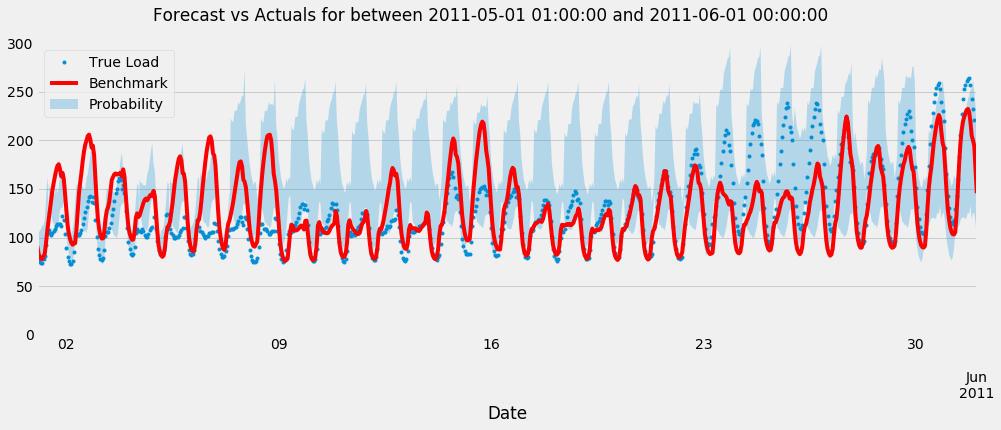

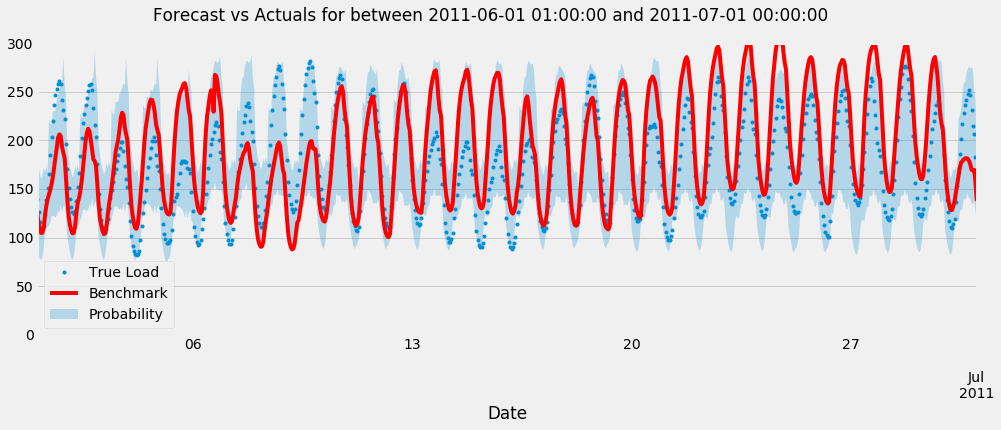

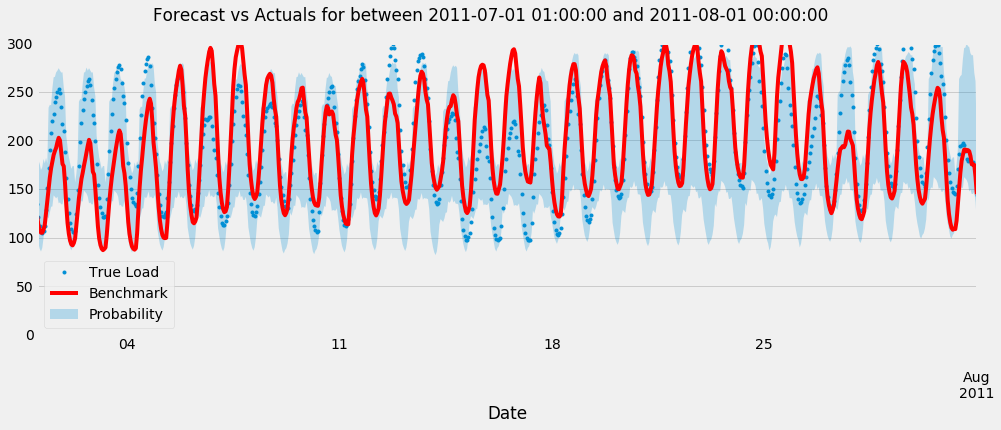

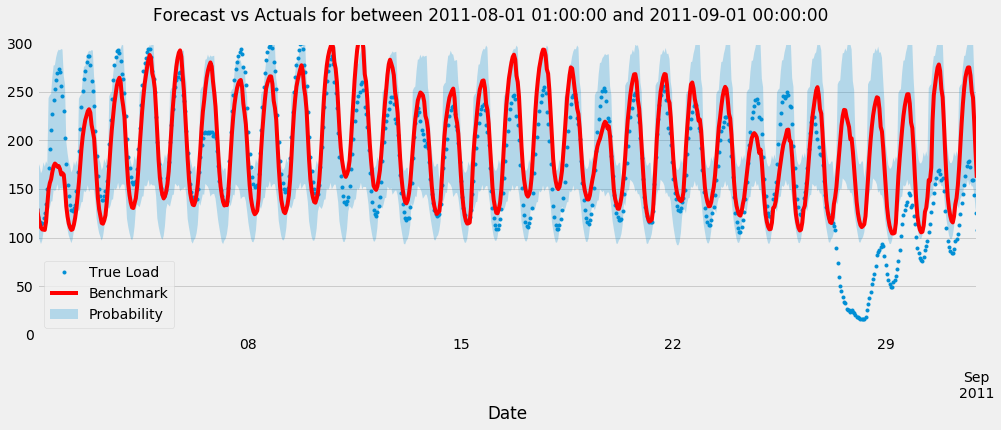

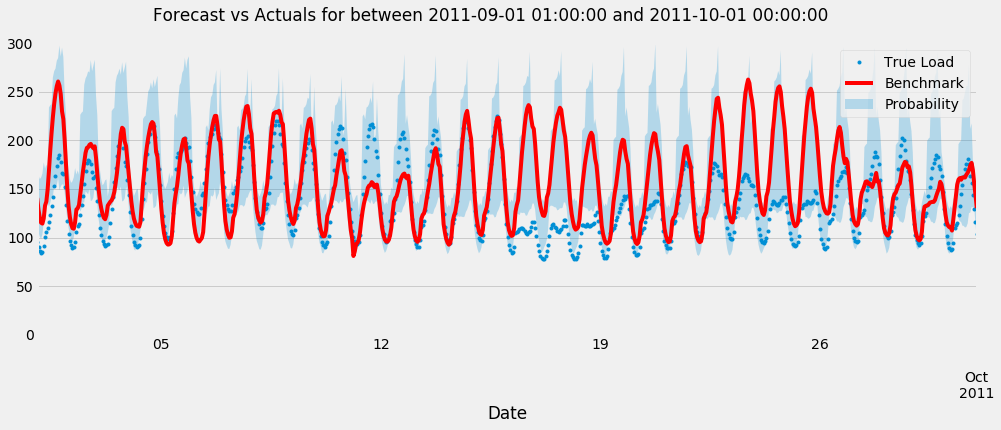

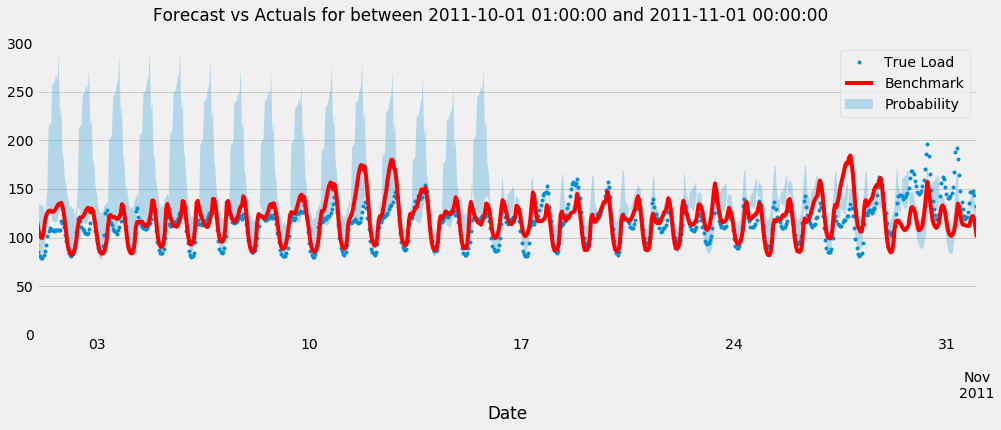

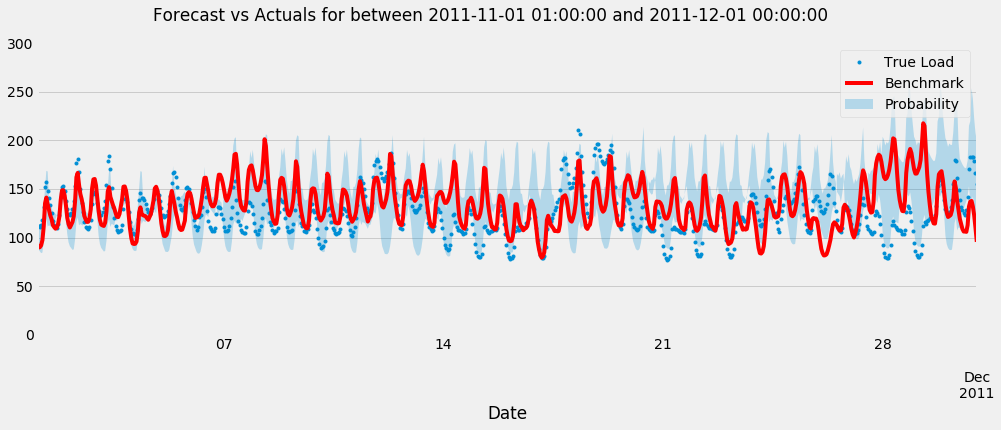

,Task #,Predicted_MSE,Predicted_Pinball,Pred_CRPS,Benchmark_MSE,Benchmark_Pinball,Benchmark_CRPS,Temp_MSE
0,Task 2,177.797,4.34817,8.32887,378.788,7.19799,14.37,58.4619
0,Task 3,493.917,5.75863,10.9389,466.271,8.12982,15.8798,68.6713
0,Task 4,3455.73,16.9668,34.266,3916.3,24.3727,49.5751,149.378
0,Task 5,1306.46,9.62254,19.0199,2388.12,18.749,37.4767,87.0031
0,Task 6,1177.41,10.414,18.1775,2915.31,23.1466,41.1121,117.23
0,Task 7,808.963,7.86322,15.2634,1245.55,13.2141,26.4325,80.7558
0,Task 8,335.875,5.77593,10.843,531.393,8.31447,16.1856,73.2714
0,Task 9,599.064,6.90278,13.2969,943.752,10.9375,21.8324,36.7952
0,Task 10,788.374,7.43192,14.0564,1616.91,17.1592,32.891,17.2787
0,Task 11,1273.35,9.8956,19.779,1141.15,13.3958,26.8077,28.6258


In [78]:
for i in range(2,16):
    if(i==2):
        metrics=predict_data(i,1000)
    else:
        metrics=predict_data(i,1000, metrics=metrics)
metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball','Pred_CRPS', 'Benchmark_MSE', 'Benchmark_Pinball','Benchmark_CRPS','Temp_MSE']
total=[]
for columns in metric_columns[1:8]:
    metrics[columns]= pd.to_numeric(metrics[columns])
    total.append(metrics[columns].sum())

array1 = np.array(['Task Totals',total[0],total[1],total[2], total[3],total[4], total[5],total[6]]).reshape(1,8)
metric_columns1=['Task #', 'Predicted_MSE', 'Predicted_Pinball','Pred_CRPS', 'Benchmark_MSE', 'Benchmark_Pinball','Benchmark_CRPS','Temp_MSE']
temp1=pd.DataFrame(columns=metric_columns1,data=array1)
metrics=metrics.append(temp1)
metrics

## Work Space below here


In [7]:
pred_task_number=15
total=0

full_data=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 1/L1-train.csv')
task2=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 2/L2-train.csv')
full_data=pd.concat([full_data,task2], ignore_index=True)
predicted_size=task2.shape[0]
total=total+predicted_size
if(pred_task_number > 2):
    for i in range(3,pred_task_number+1):
        temp=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task {}/L{}-train.csv'.format(i,i))
        full_data=pd.concat([full_data, temp], ignore_index=True)
        predicted_size=temp.shape[0] #nrows of predictied df
        ps=predicted_size
        total=ps+total

In [8]:
total

10224